In [10]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from utils.age_category import age_category, age_mother_cat
from utils.drawing import discrete_inverse_trans, \
    transform_into_marginals_clean, DFconditional
from utils.statistical_assessments import stats_assessment
from joblib import Parallel, delayed, cpu_count
import matplotlib
import warnings
from plotly.subplots import make_subplots
import plotly.express as px
import plotly.graph_objects as go
import pickle
from datetime import datetime
import os
from utils.drawing import discrete_inverse_trans, \
    transform_into_marginals_clean, DFconditional
import time
warnings.filterwarnings("ignore")

# Projection as post-processing

In [11]:
synthetic_2010_with_age = pd.read_csv("data/synthetic_2010_with_age.csv")

reference_data_2015 = pd.read_csv("data/household_full.csv")#this should be real data, but we use synthetic ones due to privacy concerns

reference_data_2015_indiv = pd.read_csv("data/synthetic_individuals.csv") #here the same

In [12]:
reference_data_2015

,hid,htype,nbcars_agg,hsize,age_discrete,gender,marital_status,employment,driving_licence,age,role,nind
0,0,10,1,1,5,2,4,4,1,55,1,1
1,1,10,1,1,5,2,1,4,1,56,1,1
2,2,10,1,1,5,2,1,4,1,55,1,1
3,3,10,1,1,5,2,1,4,1,56,1,1
4,4,10,1,1,5,2,1,4,1,62,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...
124979,56770,220,2,3,4,1,2,1,1,24,2,3
124980,56770,220,2,3,1,2,1,5,2,0,3,3
124981,56771,220,2,3,4,1,2,1,1,42,1,3
124982,56771,220,2,3,4,2,2,1,1,42,2,3


## Simulate events

In [13]:
#all rates for simulating events are available here : https://www.bfs.admin.ch/bfs/en/home/statistics/population.html
death_ratios = pd.read_csv("data\death_ratios.csv")
death_ratios = death_ratios.groupby(["Year","Age","Sex"]).Ratio.sum()
mortality_counts = pd.read_csv("data\mortality_counts.csv")
mortality_counts = mortality_counts.groupby(["Year", "Age", "Sex"]).Count.sum()

births_ratios = pd.read_csv("data\\birth_ratios.csv")
age_mother_cats = births_ratios["Age class of mother"].unique()
births_ratios = births_ratios.groupby(["Year","Age class of mother"]).Ratio.sum()

migration_ratios = pd.read_csv("data\\migration_ratios.csv")

live_births = pd.read_csv("data\\births_counts.csv")
mortality = pd.read_csv("data\mortality_counts.csv")
population = pd.read_csv("data\population_counts.csv")

births_counts = pd.read_csv("data\\births_counts.csv")
mariage_counts = pd.read_csv("data\\mariages_onlyage.csv")
divorce_counts = pd.read_csv("data\\divorces_onlyage.csv")

### Age

In [14]:
def age_increment(df):
    df["age"] = df["age"] + 1
    df["age_discrete"] = df["age"].apply(age_category)
    return df

### Births

In [15]:
def births_per_year(year):
    births = births_counts[births_counts.Year==year].copy()
    births = births[~births["Age class of mother"].isin(["Less than 20 years", "50 years or older"])]
    births = births.groupby(["Marital status of mother", "Age class of mother","Birth order"]).Count.sum()
    births_disagg = births.loc["Married"].reset_index(level=["Birth order"])
    births_married = births.loc["Married"]
    births_other = births.loc["Other"]
    for i in births_disagg.index:
        if births_married[i].sum()==0:
            display(births_other[i])
            raise ValueError(f"Error for {i}")
        births_other[i] = (births_married[i] * (births_other[i].sum()/births_married[i].sum())).values
        births_other[i] = births_other[i].astype(int)

    births_married = births_married.to_frame().reset_index()
    births_other = births_other.to_frame().reset_index()
    births_married["Marital status of mother"] = "Married"
    births_other["Marital status of mother"] = "Other"
    births = pd.concat([births_married, births_other])
    return births

def births(df, year):
    candidates = df[(df.gender==2)&(df.age>=20)&(df.age<=49)]
    candidates = candidates[["hid", "age", "htype"]]
    candidates.sort_values(["hid","age"], inplace=True)
    candidates = candidates.groupby("hid", as_index= False).first()
    candidates["in_couple"] = "Other"
    candidates.loc[candidates.htype.isin([210, 220]),"in_couple"]= "Married"
    
    candidates_indiv = df[df.hid.isin(candidates.hid.values)]
    candidates["nb_children"] = candidates["hid"].map(candidates_indiv.groupby("hid").apply(lambda x: (x.age <= candidates.loc[candidates.hid==x.hid.values[0], "age"].values[0] - 15).sum()).fillna(0).astype(int))

    candidates.drop("htype", axis=1, inplace=True)
    candidates.reset_index(drop=True, inplace=True)

    candidates["age_cat"] = pd.cut(candidates.age, bins=[0, 20, 25, 30, 35, 40, 45, 50, 120], labels=['Less than 20 years', '20-24 years', '25-29 years', '30-34 years', '35-39 years', '40-44 years','45-49 years', '50 years or older'])
    dict_nbchildren_to_order = {0:"First child", 1: "Second child", 2: "Third child", 3: "Forth child or more"}
    candidates["Birth_order"] = candidates["nb_children"].apply(lambda x : dict_nbchildren_to_order[x] if x<4 else dict_nbchildren_to_order[3])
    births = births_per_year(year)
    pop_ratio =  (df.shape[0] / population[population.Year==year].Population.sum())
    births["Count"] = (births["Count"] * pop_ratio).astype(int)
    births = births[births["Count"]>0]
    hids_with_births = []

    for row in births.iterrows():
        cand_row = candidates[(candidates.age_cat==row[1]["Age class of mother"])&
        (candidates.in_couple==row[1]["Marital status of mother"])&
        (candidates.Birth_order==row[1]["Birth order"])]
        if cand_row.shape[0]>= row[1]["Count"]:
            cand_row = cand_row.sample(n=row[1]["Count"], replace=False)
        else:
            cand_row_supp = candidates[(candidates.age_cat==row[1]["Age class of mother"])&
        (candidates.in_couple==row[1]["Marital status of mother"])&
        (candidates.Birth_order!=row[1]["Birth order"])]
            try :
                cand_row_supp = cand_row_supp.sample(n=row[1]["Count"]-cand_row.shape[0], replace=False)
                cand_row = pd.concat([cand_row, cand_row_supp])
            except :
                print(cand_row.shape[0], row[1]["Count"])
                raise ValueError(f"Not enough candidates for {row[1]}")
        hids_with_births.extend(cand_row.hid.values)

    df.loc[df.hid.isin(hids_with_births), "htype"] = df.loc[df.hid.isin(hids_with_births), "htype"].apply(lambda x : 220 if (x==210)|(x==220) else 230)
    df.loc[df.hid.isin(hids_with_births), "hsize"] += 1

    baby_data = []
    for hid in hids_with_births:
        hh = df[df.hid==hid]
        baby = hh.iloc[0:1].copy()
        baby["age"] = 0
        baby["age_discrete"] = 1
        baby["gender"] = 1 if np.random.rand()<0.5 else 2
        baby["employment"] = 5
        baby["driving_licence"] = 2
        baby["role"] = hh.shape[0] + 1
        baby["marital_status"] = 1
        baby_data.append(baby)
    
    df = pd.concat([df] + baby_data)

    # Sort by hid and role
    df.sort_values(by=["hid", "age"], ascending=[True, False], inplace=True)
    df.reset_index(drop=True, inplace=True)
    return df


### Death

In [16]:
def adapt_hh(df, hid_w_changes, death=False):
    df_other = df[~df.hid.isin(hid_w_changes)]
    for hid in hid_w_changes:
        hh = df[df.hid==hid]
        # If hh is empty, then do nothing
        if hh.shape[0]==0:
            continue
        # If households with children only, relocate children to other households with one children at least, then adapt those hh and continue
        if hh.age.iloc[0] <18:
            # Find all households with one child at least (and older than this one)
            hids_with_children = df_other[(df_other.age<18)&(df_other.age>=hh.age.iloc[0]-2)].hid.unique()
            # If no such households, then raise error
            if hids_with_children.shape[0]==0:
                raise ValueError("No household with children to relocate children")
            # If there are such households, then relocate children to one of them
            for child in hh.index:
                # Find a household with one child at least
                hid_with_child = np.random.choice(hids_with_children)
                new_htype= df.loc[df.hid==hid_with_child, "htype"].values[0]
                new_car = df.loc[df.hid==hid_with_child, "nbcars_agg"].values[0]
                # Relocate child
                df.loc[child, "hid"] = hid_with_child
                df.loc[child, "htype"] = new_htype
                df.loc[child, "nbcars_agg"] = new_car
                # Adapt hsize
                df.loc[df.hid==hid_with_child, "hsize"] = df.loc[df.hid==hid_with_child, "hsize"].shape[0] 
            continue
        # If size of household is 1, then change type to single, adapt marital status to 3 (widowed) if type was 210 or 220
        if hh.shape[0]==1:
            if hh.htype.iloc[0] in [210, 220]:
                if death:
                    df.loc[df.hid==hid, "marital_status"] = 3
                elif df.loc[df.hid==hid, "marital_status"].min()==2:
                    df.loc[df.hid==hid, "marital_status"] = 1
            df.loc[df.hid==hid, "htype"] = 10
            df.loc[df.hid==hid, "hsize"] = 1
            continue
        # else :
        # If htype 30, then no specific treatment
        # If Htype 10, should not happen as we have 2 people at least
        # If Htype 210, should not happen as we have 2 people at least
        if hh.htype.iloc[0] in [10, 210]:
            raise ValueError(f"Household {hid} has htype {hh.htype.iloc[0]} and size {hh.shape[0]}")
        # If htype 220, several things to check
        # is there a couple in the household (look for the youngest couple of two adults >24 with age difference <15) ?
        # if yes, then check if there are people younger than min age of couple -15 (means children) and if yes, keep type 220 and adapt hsize else change type to 210 and adapt hsize
        # if no, it's a single parent household and then htype to 230, marital status to 4 (widowed) to oldest adult and adapt hsize
        if hh.htype.iloc[0] == 220:
            # Find the two youngest adults
            youngest_adults = hh[hh.age>=18].sort_values(by="age")
            # If there are less than 2 adults, then raise error
            if youngest_adults.shape[0]<2:
                df.loc[df.hid==hid, "htype"] = 230
                df.loc[df.hid==hid, "hsize"] = df.loc[df.hid==hid].shape[0]
                oldest = hh[hh.age==hh.age.max()].index
                if hh.age.iloc[0] - 15 > hh.age.iloc[1]:
                    if death:
                        df.loc[oldest, "marital_status"] = 3
                    elif df.loc[oldest, "marital_status"].min()==2:
                        df.loc[oldest, "marital_status"] = 1
                else:
                    df.loc[df.hid==hid, "htype"] = 30
                continue
            find_couple = False
            while (not find_couple)&(youngest_adults.shape[0]>=2):
                if youngest_adults.age.iloc[0] - youngest_adults.age.iloc[1] <= 15:
                    find_couple = True
                else:
                    youngest_adults = youngest_adults.iloc[1:]
            # If there are people younger than min age of couple -15 (means children) and if yes, keep type 220 and adapt hsize else change type to 210 and adapt hsize
            if find_couple:
                if hh[hh.age<youngest_adults.age.min()-15].shape[0]>0:
                    df.loc[df.hid==hid, "hsize"] = df.loc[df.hid==hid].shape[0]
                    continue
                else:
                    if df.loc[df.hid==hid].shape[0] == 2:
                        df.loc[df.hid==hid, "htype"] = 210
                    elif df.loc[df.hid==hid].shape[0] == 3:
                        df.loc[df.hid==hid, "htype"] = 230
                    else:
                        df.loc[df.hid==hid, "htype"] = 30
                    df.loc[df.hid==hid, "hsize"] = df.loc[df.hid==hid].shape[0]
                    continue
            else:
                df.loc[df.hid==hid, "htype"] = 230
                df.loc[df.hid==hid, "hsize"] = df.loc[df.hid==hid].shape[0]
                oldest = hh[hh.age==hh.age.max()].index
                if death:
                    df.loc[oldest, "marital_status"] = 3
                elif df.loc[oldest, "marital_status"].min()==2:
                    df.loc[oldest, "marital_status"] = 1
                continue


        # If htype 230, should be that the adult is still here after previous checks so nothing to do except adapt hsize
        if hh.htype.iloc[0] == 230:
            df.loc[df.hid==hid, "hsize"] = df.loc[df.hid==hid].shape[0]
            if hh.age.iloc[0] - 15 < hh.age.iloc[1]:
                df.loc[df.hid==hid, "htype"] = 30

            continue

        # adapt hsize
        if hh.htype.iloc[0] == 30:
            df.loc[df.hid==hid, "hsize"] = df.loc[df.hid==hid].shape[0]
            continue

        raise ValueError("htype not recognized")
    # adapt role
    df.sort_values(by=["hid", "age"], ascending=[True, False], inplace=True)
    df.reset_index(drop=True, inplace=True)
    df["role"] = df.groupby("hid").cumcount()+1

    return df

def death_in_household(df, year):
    # Death
    death_ratios_year = death_ratios[year]
    candidates = df[["hid", "age", "gender"]]
    candidates["gender"]=candidates["gender"].replace({1:"Male", 2:"Female"})
    # If age >= 100, then the person dies
    # If age == 0, we don't kill as we generate only live births and death ratios account for live or dead births
    def to_kill(x):
        if x.age == 0:
            return 0
        elif x.age >= 100:
            return 1
        else:
            return np.random.binomial(1,death_ratios_year[tuple(x)])
    died = candidates[["age", "gender"]].apply(lambda x : to_kill(x), axis = 1)
    df.drop(died[died==1].index,inplace=True)
    hid_w_changes = candidates[died==1].hid.unique()

    df = adapt_hh(df, hid_w_changes, death=True)
    return df


### Migration

In [17]:
def create_hh_from_indiv(indivs, df_og):


    
    df_hh = df_og.copy()
    indivs.reset_index(drop=True, inplace=True)
    # Check indivs with hsize 1
    indivs_hsize_1 = indivs[indivs.hsize==1]
    indivs_hsize_1.reset_index(drop=True, inplace=True)
    # Adapt hid
    indivs_hsize_1["hid"] = df_hh.hid.max()+1+indivs_hsize_1.index
    # Include them in df_hh
    df_hh = pd.concat([df_hh, indivs_hsize_1], axis=0)

    # Remove them from indivs
    indivs = indivs[indivs.hsize!=1]

    
    # Check indivs with htype 210
    indivs_210 = indivs[indivs.htype==210]
    # Create a matching
    # Separate by gender
    males = indivs_210[(indivs_210.gender==1)&(indivs_210.role<3)].sort_values(by="age", ascending=False)
    females = indivs_210[(indivs_210.gender==2)&(indivs_210.role<3)].sort_values(by="age", ascending=False)
    if len(males) < len(females):
        smaller = males
        larger = females
    else:
        smaller = females
        larger = males
    idx_remove = []
    hh_2_list = []
    for idx,person in smaller.iterrows():
        cand_p = larger[(larger.age>person.age-10)&(larger.age<person.age+10)]
        if cand_p.shape[0] == 0:
            continue
        other = cand_p.iloc[0:1]
        hh_2 = pd.concat([smaller.loc[[idx]], other])
        

        for x in [idx, other.index.values[0]]:
            if x in idx_remove:
                display(person.to_frame())
                display(other)
                display(df_hh[df_hh.hid.isin([indivs.loc[x].hid])])
                raise ValueError(f"Index already in idx_remove {x}")
        idx_remove.append(idx)
        idx_remove.extend(other.index.values)
        hh_2["hid"] = df_hh.hid.max()+1+len(hh_2_list)
        hh_2["marital_status"] = 2
        hh_2["nbcars_agg"] = person.nbcars_agg
        hh_2_list.append(hh_2)
        larger.drop(other.index, inplace=True)
    df_hh = pd.concat([df_hh]+hh_2_list, axis=0)


    # Check which index is a duplicate in idx_remove
    

    indivs.drop(idx_remove, inplace=True)
    
    # Check indivs with htype 220
    indivs_220 = indivs[indivs.htype==220]
    # Separate by gender
    males = indivs_220[(indivs_220.gender==1)&(indivs_220.role<3)].sort_values(by="age", ascending=False)
    females = indivs_220[(indivs_220.gender==2)&(indivs_220.role<3)].sort_values(by="age", ascending=False)
    children = indivs_220[indivs_220.role>=3]
    if len(males) < len(females):
        smaller = males
        larger = females
    else:
        smaller = females
        larger = males
    idx_remove = []
    hh_2_list = []
    for idx,person in smaller.iterrows():
        cand_p = larger[(larger.age>person.age-10)&(larger.age<person.age+10)]
        if cand_p.shape[0] == 0:
            continue
        other = cand_p.iloc[0:1]
        min_age = min(person.age, other.age.values[0])
        max_age = max(person.age, other.age.values[0])
        cand_c = children[(children.age<min_age-15)&(children.age>max_age-40)]
        if cand_c.shape[0] == 0:
            hh_child = pd.DataFrame()
        else:
            size = min(person.hsize-2, cand_c.shape[0])
            hh_child = cand_c.sample(size)
        hh_2 = pd.concat([smaller.loc[[idx]], other, hh_child])
        hh_2 = hh_2.astype("int64")
        idx_remove.append(idx)
        idx_remove.extend(other.index.values)
        idx_remove.extend(hh_child.index.values)
        hh_2["hid"] = df_hh.hid.max()+1+len(hh_2_list)
        hh_2.loc[[idx, other.index[0]],"marital_status"] = 2
        hh_2["nbcars_agg"] = person.nbcars_agg
        hh_2["hsize"] = hh_2.shape[0]
        hh_2_list.append(hh_2)
        larger.drop(other.index, inplace=True)
        children.drop(hh_child.index, inplace=True)
    df_hh = pd.concat([df_hh]+hh_2_list, axis=0)
    indivs.drop(idx_remove, inplace=True)


    # Check indivs with htype 230
    indivs_230 = indivs[indivs.htype==230]
    parents = indivs_230[indivs_230.role==1]
    children = indivs_230[indivs_230.role>=2]
    idx_remove = []
    hh_2_list = []
    for idx,person in parents.iterrows():
        cand_c = children[(children.age<person.age-15)&(children.age>person.age-40)]
        if cand_c.shape[0] == 0:
            hh_child = pd.DataFrame()
        else:
            size = min(person.hsize-2, cand_c.shape[0])
            hh_child = cand_c.sample(size)
        hh_2 = pd.concat([parents.loc[[idx]], hh_child])
        hh_2 = hh_2.astype("int64")
        idx_remove.append(idx)
        idx_remove.extend(hh_child.index.values)
        hh_2["hid"] = df_hh.hid.max()+1+len(hh_2_list)
        hh_2["nbcars_agg"] = person.nbcars_agg
        hh_2["hsize"] = hh_2.shape[0]
        hh_2_list.append(hh_2)
        children.drop(hh_child.index, inplace=True)
    df_hh = pd.concat([df_hh]+hh_2_list, axis=0)
    indivs.drop(idx_remove, inplace=True)

    
    # All remaining indivs are in htype 30
    indivs.sort_values(by="age", ascending=False, inplace=True)
    hhs = []
    while indivs.shape[0]>0:
        adults = indivs[indivs.age>=18]
        children = indivs[indivs.age<18]
        if adults.shape[0] == 0:
            hh_idx = np.random.randint(0, len(hhs))
            hh = hhs[hh_idx]
            child = children.iloc[0:1]
            child["hid"] = hh.hid.values[0]
            hh = pd.concat([hh, child])
            hh["hsize"] = hh.shape[0]
            hh["htype"] = 30
            hh["nbcars_agg"] = hh.nbcars_agg.values[0]
            hhs[hh_idx] = hh
            indivs.drop(child.index, inplace=True)
            continue
        first_adult = adults.iloc[0:1]
        hsize = min(first_adult.hsize.values[0], indivs.shape[0])
        hh = indivs.drop(first_adult.index.values[0],axis=0).sample(hsize-1)
        hh = pd.concat([first_adult, hh])
        hh["hid"] = df_hh.hid.max()+len(hhs)+1
        hh["hsize"] = hh.shape[0]
        hh["htype"] = 30
        hh["nbcars_agg"] = hh.nbcars_agg.values[0]
        hhs.append(hh)
        indivs.drop(hh.index, inplace=True)
    df_hh = pd.concat([df_hh, *hhs], axis=0)


    df_hh.sort_values(by=["hid", "age"], ascending=[True, False], inplace=True)
    df_hh.reset_index(drop=True, inplace=True)
    df_hh["role"] = df_hh.groupby("hid").cumcount()+1
    return df_hh


def migration(df, year):
    # TODO : create individuals and group them, or remove them
    migration_ratios_year = migration_ratios[migration_ratios.Year == year]
    migration_ratios_year.Sex.replace({"Male":1, "Female":2}, inplace=True)
    migration_ratios_year = migration_ratios_year.groupby(["Age", "Sex"]).Ratio.sum()

    counts_sample = synthetic_2010_with_age[["age", "gender"]].value_counts()
    intersection = migration_ratios_year.index.intersection(counts_sample.index.values)
    to_change = (migration_ratios_year[intersection] * counts_sample[intersection.values]).astype(int)
    to_add = to_change[to_change>0]
    to_remove = to_change[to_change<0]

    for i in to_remove.index:
        age, sex = i
        df_i = df[(df.age == age) & (df.gender==sex)]
        n = -to_remove[i]
        if n > df_i.shape[0]:
            n = df_i.shape[0]
        df_remove = df_i.sample(n)
        df.drop(df_remove.index, inplace=True)
        hid_w_changes = df_remove.hid.unique()
        df = adapt_hh(df, hid_w_changes)

    indivs = pd.DataFrame(columns=df.columns)
    toadd_list = []
    weights = df.htype.value_counts(normalize=True)
    for i in to_add.index:
        age, sex = i
        df_i = df[(df.age == age) & (df.gender==sex)]
        n = to_add[i]
        # build weights according to hhtype frequency
        weights_i = df_i.htype.apply(lambda x: weights[x])
        df_add = df_i.sample(n, weights=weights_i, replace=True)
        toadd_list.append(df_add)
    indivs = pd.concat([indivs, *toadd_list], axis=0)
    df = create_hh_from_indiv(indivs, df)
    df = df.astype("int64")

    return df


### Mariage

In [18]:
def mariage(df, year):
    # Takes only people from households 10, 230 or 30
    df_m = df[(df.htype==10)|(df.htype==230)|(df.htype==30)]
    # Keep more than 18 yo
    df_m = df_m[df_m.age>=18]
    
    pop_ratio =  (df.shape[0] / population[population.Year==year].Population.sum())
    mariage_year = mariage_counts[mariage_counts.Year==year].groupby(["Age_of_husband", "Age_of_wife"]).Count.sum()
    mariages = (pop_ratio * mariage_year).astype(int)

    # Create new column age_cat '20-24 ans', '25-29 ans', '30-34 ans', '35-39 ans', '40-49 ans', '50-59 ans', '60 ans ou plus', 'Moins de 20 ans'
    df_m["age_cat"] = pd.cut(df_m.age, bins=[0, 20, 25, 30, 35, 40, 50, 60, 120], labels=['Moins de 20 ans', '20-24 ans', '25-29 ans', '30-34 ans', '35-39 ans', '40-49 ans', '50-59 ans', '60 ans ou plus'])

    to_adapt = []
    for idx in mariages.index:
        age_h = idx[0]
        age_w = idx[1]
        df_h = df_m[(df_m.age_cat==age_h)&(df_m.gender==1)]
        df_w = df_m[(df_m.age_cat==age_w)&(df_m.gender==2)]
        n = mariages.loc[idx]
        if n > df_h.shape[0]:
            n = df_h.shape[0]
        if n > df_w.shape[0]:
            n = df_w.shape[0]
        df_h = df_h.sample(n)
        df_w = df_w[~df_w.hid.isin(df_h.hid.unique())].sample(n)
        to_drop = []
        for i in range(n):
            new_hid = df.hid.max()+1
            to_adapt.extend([df_h.iloc[i].hid, df_w.iloc[i].hid])
            # We keep the individual and all people in the household with age < husband age -15 or wife age -15
            df.loc[(df.index == df_h.iloc[i].name) | ((df.hid == df_h.iloc[i].hid) & (df.age < df_h.iloc[i].age-15)), "hid"] = new_hid
            df.loc[(df.index == df_w.iloc[i].name) | ((df.hid == df_w.iloc[i].hid) & (df.age < df_w.iloc[i].age-15)), "hid"] = new_hid
            to_drop.extend(df.loc[df.hid==new_hid].index.intersection(df_m.index))
            df.loc[(df.index == df_h.iloc[i].name),"marital_status"] = 2
            df.loc[(df.index == df_w.iloc[i].name),"marital_status"] = 2
            
            df.loc[df.hid == df_h.iloc[i].hid, "nbcars_agg"] = np.minimum(df_h.iloc[i].nbcars_agg, df.loc[df.hid == df_h.iloc[i].hid].shape[0])
            df.loc[df.hid == df_w.iloc[i].hid, "nbcars_agg"] = np.minimum(df_w.iloc[i].nbcars_agg, df.loc[df.hid == df_w.iloc[i].hid].shape[0])

            df.loc[df.hid == new_hid, "nbcars_agg"] = df_h.iloc[i].nbcars_agg + df_w.iloc[i].nbcars_agg
            new_size = df.loc[df.hid == new_hid].shape[0]
            df.loc[df.hid == new_hid, "hsize"] = new_size
            df.loc[df.hid == new_hid, "htype"] = 210 if new_size == 2 else 220
        
        df_m.drop(to_drop, inplace=True)
        
    df = adapt_hh(df, to_adapt)
    df.sort_values(by=["hid", "age"], ascending=[True, False], inplace=True)
    df.reset_index(drop=True, inplace=True)
    df["role"] = df.groupby("hid").cumcount()+1

    return df

### Divorce

In [19]:
def divorce(df, year):
    # Takes htype 210 and 220
    df_d = df[(df.htype==210)]
    # keep htype 220
    df_d_220 = df[(df.htype==220)]
    # keep hid where more than 2 adults
    df_adults = df_d_220[df_d_220.age>=18]
    df_adults_s2 = df_adults.groupby("hid").filter(lambda x: x.shape[0]==2)
    df_d = df_d.append(df_adults_s2)
    df_hh_s = df_d_220[~df_d_220.hid.isin(df_adults_s2.hid)]
    df_hh_s = df_hh_s[(df_hh_s.age>=18)|(df_hh_s.groupby("hid").age.shift()>=18)]
    df_hh_s["age_to_min"] = df_hh_s.age - df_hh_s.groupby("hid").age.transform("min")
    df_hh_s = df_hh_s[df_hh_s["age_to_min"]>10]
    df_hh_s["age_diff"] = df_hh_s.groupby("hid").age.diff(-1)
    df_hh_s = df_hh_s[df_hh_s.role < df_hh_s.hsize] # Drop if role = hsize
    df_d_220_firsts = df_hh_s[df_hh_s.age_diff<=15]
    df_d_220_firsts = df_d_220_firsts.groupby("hid",as_index=False).head(1)
    # drop df_d_220 index from df_d except firsts and firsts+1
    to_keep = df_hh_s.loc[df_d_220_firsts.index | (df_d_220_firsts.index +1)]
    hh_with_couples = to_keep.hid.unique()
    df_d = df_d.append(to_keep.drop(["age_to_min", "age_diff"],axis=1))
    df_d_220_rest = df_hh_s[~df_hh_s.hid.isin(hh_with_couples)]

    # Adapt weird cases
    # # If Age of first - age of second >15, then change htype to 230
    # # Else : change htype to 30
    hids = df_d_220_rest.groupby("hid").filter(lambda x: x.shape[0]==1).hid.unique()
    house = df[df.hid.isin(hids)]
    test = pd.DataFrame([house[house['role'] == 1]['age'].values,\
        house[house['role'] == 2]['age'].values,
        house[house['role'] == 1]["hid"].values]).T
    test.columns = ['age1','age2', 'hid']
    to_adapt = test[(test.age1 - test.age2) > 15]
    df.loc[df.hid.isin(to_adapt.hid), "htype"] = 230
    to_adapt = test[(test.age1 - test.age2) <= 15]
    df.loc[df.hid.isin(to_adapt.hid), "htype"] = 30

    df_d_220_rest = df_d_220_rest[~df_d_220_rest.hid.isin(hids)]
    to_keep_index = df_d_220_rest.groupby("hid").age_diff.idxmin().values
    to_keep = df_d_220_rest.loc[np.concatenate([to_keep_index, to_keep_index + 1])]
    df_d = df_d.append(to_keep.drop(["age_to_min", "age_diff"],axis=1))

    # Remove homo couples
    homo = (df_d.groupby("hid").gender.diff(-1) == 0)
    hids = df_d.loc[homo[homo].index].hid.unique()
    df_d = df_d[~df_d.hid.isin(hids)]

    # df_d contains the couples that may divorce

    pop_ratio =  (df.shape[0] / population[population.Year==year].Population.sum())
    divorce_year = divorce_counts[divorce_counts.Year==year].groupby(["Age_of_husband", "Age_of_wife"]).Count.sum()
    divorces = (pop_ratio * divorce_year).astype(int)

    # Create new column age_cat 'Moins de 20 ans', '20-29 ans', '30-39 ans', '40-49 ans', '50-59 ans', '60-69 ans','70-79 ans', '80-89 ans', '90 ans ou plus'
    df_d["age_cat"] = pd.cut(df_d.age, bins=[0, 20, 30, 40, 50, 60, 70, 80, 90, 120], labels=['Moins de 20 ans', '20-29 ans', '30-39 ans', '40-49 ans', '50-59 ans', '60-69 ans','70-79 ans', '80-89 ans', '90 ans ou plus'])
    
    for idx in divorces.index:
        age_h = idx[0]
        age_w = idx[1]
        men_hids = df_d[(df_d.age_cat==age_h)&(df_d.gender==1)].hid.unique()
        women_hids = df_d[(df_d.age_cat==age_w)&(df_d.gender==2)].hid.unique()
        # Intersect the two lists
        couples_hids = np.intersect1d(men_hids, women_hids)
        n = divorces.loc[idx]
        if n > couples_hids.shape[0]:
            n = couples_hids.shape[0]
        couples_hids = np.random.choice(couples_hids, n, replace=False)
        for hid in couples_hids:
            couple = df_d[df_d.hid==hid]
            single_idx = np.random.choice([0,1])
            single = couple.iloc[single_idx]
            df.loc[single.name, "marital_status"] = 4
            df.loc[single.name, "htype"] = 10
            df.loc[single.name, "hid"] = df.hid.max()+1
            df.loc[single.name, "hsize"] = 1 
            df.loc[single.name, "nbcars_agg"] = 1 if (single.nbcars_agg >= 2 & single.driving_licence==1) else 0
            
            other = couple.iloc[1-single_idx]
            df.loc[other.name, "marital_status"] = 4
            df.loc[df.hid == hid, "htype"] = 230 if other.htype == 220 else 10
            df.loc[df.hid == hid, "nbcars_agg"] = df.loc[df.hid == hid, "nbcars_agg"] - df.loc[single.name, "nbcars_agg"]
            df.loc[df.hid == hid, "hsize"] = df.loc[df.hid == hid, "hsize"] - 1

    df.sort_values(by=["hid", "age"], ascending=[True, False], inplace=True)
    df.reset_index(drop=True, inplace=True)
    df["role"] = df.groupby("hid").cumcount()+1
    
    return df

### Leaving house

In [20]:
def leave_household(df, atparents_percent = 0.67):
    """"Young people leave their parents' house to live alone."""
    df_aux = df.copy()
    df_aux["age_to_min"] = df_aux.age - df_aux.groupby("hid").age.transform(min)
    df_aux["age_prev"] = df_aux.groupby("hid").age.shift(1)

    df_young = df_aux[(df_aux.age <= 28)&(df_aux.age>=15)]
    # check young which live with their parents
    candidates = df_young.loc[(((df_young.role>=3) & (df_young.htype==220))|((df_young.role>=2) & (df_young.htype==230)))&(df_young.age_prev>=15)] # why age_prev>=15 ?8
    actual_percent = candidates.shape[0] / df_young.shape[0]

    if actual_percent > atparents_percent:
        amount = int((actual_percent - atparents_percent) * df_young.shape[0])
        candidates["weights"] = pd.cut(candidates.age, bins=[14, 18, 22, 26, 30], labels=[0.1, 1, 5, 10]).tolist()
        candidates = candidates.sample(amount, weights=candidates.weights, replace=False)
        
    else:
        return df

    hids_to_adapt = candidates.hid.unique()
    candidates_single=[]
    for idx in candidates.index:
        candidate = candidates.loc[idx]
        children = df[(df.hid==candidate.hid)&(df.age <= candidate.age-18)]
        
        if children.shape[0] == 0:
            candidates_single.append(candidate.name)
        else:
            all_indexes = children.index.tolist() + [candidate.name]
            df.loc[all_indexes, "htype"] = 230
            df.loc[all_indexes, "hsize"] = 1 + children.shape[0]
            df.loc[all_indexes, "nbcars_agg"] = 1 if ((candidate.nbcars_agg >= 2) & (candidate.driving_licence==1)) else 0
            df.loc[all_indexes, "hid"] = df.hid.max()+1

    df.loc[candidates_single, "htype"] = 10
    df.loc[candidates_single, "hsize"] = 1
    df.loc[candidates_single, "nbcars_agg"] = 1 if ((candidate.nbcars_agg >= 2) & (candidate.driving_licence==1)) else 0
    df.loc[candidates_single, "hid"] = df.hid.max()+np.arange(1, len(candidates_single)+1)
    df.loc[candidates_single, "marital_status"] = 1

    df = adapt_hh(df, hids_to_adapt)

    df.sort_values(by=["hid", "age"], ascending=[True, False], inplace=True)
    df.reset_index(drop=True, inplace=True)
    df["role"] = df.groupby("hid").cumcount()+1
    
    return df

### Employment change

In [21]:
cond_employment = DFconditional(synthetic_2010_with_age[["age", "gender", "employment"]], "employment")

def draw_next_employment(row):
    if row.age < 15:
        return 5
    # if (row.employment == 3)|(row.age < 24):
    try :
        cond = cond_employment
        index = discrete_inverse_trans(transform_into_marginals_clean(cond.loc[(row.age, row.gender)].tolist()))
        unique = sorted(cond.loc[(row.age, row.gender)].index)
        return unique[index - 1]
    except :
        if row.age > 64:
            return 4
        else:
            try: 
                cond = cond_employment
                index = discrete_inverse_trans(transform_into_marginals_clean(cond.loc[(row.age+1, row.gender)].tolist()))
                unique = sorted(cond.loc[(row.age+1, row.gender)].index)
            except:
                raise ValueError(f"{row}")

## Algorithm

In [22]:
def predict_sample(sample, t=1, year=2010):
    """Predict the sample for t years from year."""

    predictive_sample = sample.copy()

    for i in range(t):
        print(f"Year {year}")
        t0 = time.time()
        # Age increment
        predictive_sample = age_increment(predictive_sample)
        # print(f"Age increment : {time.time()-t0}")
        
        
        t0 = time.time()
        # Birth for female population
        predictive_sample = births(predictive_sample, year)
        # print(f"Births : {time.time()-t0}")
        predictive_sample = predictive_sample.astype(int)

        t0 = time.time()
        # Death
        predictive_sample = death_in_household(predictive_sample, year)
        # print(f"Death : {time.time()-t0}")

        t0 = time.time()
        # Net migration
        predictive_sample = migration(predictive_sample, year)
        # print(f"Net migration : {time.time()-t0}")

        t0 = time.time()
        # Mariage
        predictive_sample = mariage(predictive_sample, year)
        # print(f"Mariage : {time.time()-t0}")

        t0 = time.time()
        # Divorce
        predictive_sample = divorce(predictive_sample, year)
        # print(f"Divorce : {time.time()-t0}")

        t0 = time.time()
        # Leave household
        predictive_sample = leave_household(predictive_sample)
        # print(f"Leave household : {time.time()-t0}")

        # Increment year
        year +=1

        # plot_marginals([synthetic_2010_with_age[synthetic_2010_with_age.role==1], predictive_sample[predictive_sample.role==1]],"htype",["ref", "synth"], [10, 30, 210, 220, 230])

    t0 = time.time()
    # Change employment
    predictive_sample["employment"] = predictive_sample[["age", "gender"]].apply(draw_next_employment, axis = 1)
    # print(f"Employment : {time.time()-t0}")
    
    return predictive_sample

In [23]:
os.makedirs("results/proj2010_2015", exist_ok=True)
#several iterations for bootstrap
for b in range(97,100):
    predictive_sample_2010_2015 = predict_sample(synthetic_2010_with_age, t=6, year=2010)
    predictive_sample_2010_2015.to_csv(f"results/proj2010_2015/synthetic_2010_2015_{b}.csv", index=False)

Year 2010
Year 2011
Year 2012
Year 2013
Year 2014
Year 2015
Year 2010
Year 2011
Year 2012
Year 2013
Year 2014
Year 2015
Year 2010
Year 2011
Year 2012
Year 2013
Year 2014
Year 2015


In [24]:
#or only once
predictive_sample_2010_2015 = predict_sample(synthetic_2010_with_age, t=6, year=2010)

Year 2010
Year 2011
Year 2012
Year 2013
Year 2014
Year 2015


# Plotting

In [25]:
sns.set_style("whitegrid")

# For the Python notebook
%matplotlib inline

font = {'family' : 'arial',
'weight' : 'normal',
'size'   : 10}
matplotlib.rc('font', **font)

colors = ['black', 'darkgray', "gray", "lightgray", "silver", "whitesmoke"]
labels = ['Original', 'Simulation synthetic']
labels_name = [['<14','14-18','18-24','24-44','44-65','>65'],
               ["Male", "Female"],
               ["Yes", "No"],]

labels_name_1 = [['<14','14-18','18-24','24-44','44-65','>65'], ['1','2','3','4','5'],
               ["Male", "Female"]]

cols = ["age_discrete", "gender","driving_licence"]
cols_1 = ["age_discrete", "employment","gender"]
    
def plot_marginals_2(dfs,cols,labels_name, labels = labels, boostrap=False, b=100):

    fig,ax = plt.subplots(1, len(cols), figsize=(15,3))

    for i_col, col in enumerate(cols):

        probs = [df[col].value_counts()/len(df) for df in dfs]

        dct = {}
        for l in labels:
            dct[l] = []
        
        idx = sorted(list(dfs[0][col].unique()))
        for i in idx:

            for j, l in enumerate(labels):      
                try:
                    dct[l].append(probs[j].loc[i])
                except:
                    print("s")
                    dct[l].append(0)


        tmp_df = pd.DataFrame(dct, index=idx)

        if boostrap:
            n = len(dfs[1])
            bs_probs = []
            for _ in range(b):
                bs_sample = dfs[1].sample(n, replace=True)
                probs = bs_sample[col].value_counts()/len(bs_sample)
                bs_probs.append(probs)

            bs_probs = pd.DataFrame(bs_probs)
            bs_probs = bs_probs.quantile([0.025, 0.975], axis=0)
            bs_probs = bs_probs.T
            bs_probs.columns = ['lower', 'upper']
            bs_probs['lower'] = tmp_df[labels[1]] - bs_probs['lower']
            bs_probs['upper'] = bs_probs['upper'] - tmp_df[labels[1]]
            bs_probs = bs_probs[['lower', 'upper']].values.T

            tmp_df.plot(ax = ax[i_col], figsize=(4,4), kind='bar', color=colors, yerr=[np.zeros_like(bs_probs), bs_probs], rot= 45)

        else :
            tmp_df.plot(ax = ax[i_col],figsize=(4,4), kind='bar', color=colors, rot= 45)
            

        ax[i_col].set_xticklabels(labels_name[i_col])
        ax[i_col].set_title(col)
        ax[i_col].set_ylabel("Frequency")
        ax[i_col].set_xlabel("")
        ax[i_col].set_title(col)

        # Remove legend
        ax[i_col].legend().set_visible(False)

    ax[i_col].legend(labels)
    fig.suptitle(f'Marginal distributions')
    fig.show()

    # Figsize is overriden by the figsize of the subplots
    fig.set_size_inches(15,4)

    return

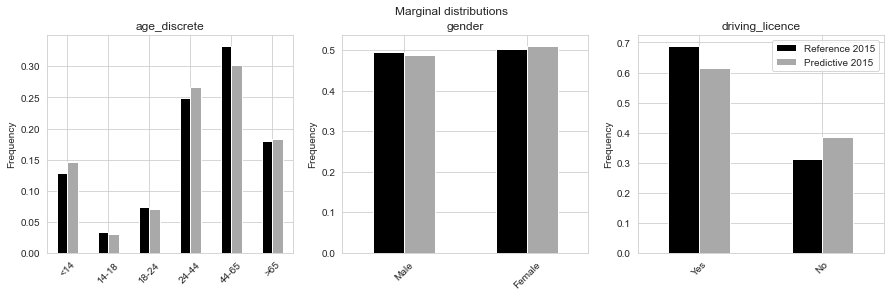

In [26]:
plot_marginals_2([reference_data_2015, predictive_sample_2010_2015],cols,labels_name, labels =  ["Reference 2015", "Predictive 2015"]);

In [27]:
results = stats_assessment(reference_data_2015, predictive_sample_2010_2015, aggregation_level=1, ignore_cols=["nind","age_discrete"])
df_results = pd.DataFrame(results)
df_results

,age,hid,role,marital_status,driving_licence,employment,nbcars_agg,hsize,gender,htype
mae,0.001729,0.000008,0.002125,0.004751,0.073620,0.012830,0.004607,0.005894,0.007617,0.015881
rmse,0.002254,0.000011,0.003762,0.005854,0.073620,0.014019,0.008002,0.010798,0.007617,0.020531
srmse,0.225368,0.799665,0.052668,0.023415,0.147239,0.070093,0.080022,0.140368,0.015234,0.102653
r2,0.734065,0.082767,0.999207,0.999063,0.848427,0.994361,0.997204,0.989174,-3.191574,0.979656
corr,0.870971,0.454439,0.999674,0.999687,1.000000,0.997529,0.998843,0.995024,1.000000,0.989855


## Bootstrap confidence interval for projection

In [28]:
def get_predictive_stats(cols = ["age_discrete", "employment", "gender"]):
    predictive_sample = predict_sample(synthetic_2010_with_age, t=6, year=2010)
    results = stats_assessment(reference_data_2015, predictive_sample, aggregation_level=1, ignore_cols=["nind","age_discrete"])
    df_results = pd.DataFrame(results)
    agg_results = df_results.mean(axis=1)
    n = predictive_sample.shape[0]
    marginals = [(predictive_sample[col].value_counts() / n).sort_index() for col in cols]
    return agg_results, marginals

B = 2 #change to bigger number
number_of_parallel_jobs = min(cpu_count(), B)

bootstrap_stats, bootstrap_marginals = zip(
    *Parallel(n_jobs=number_of_parallel_jobs, prefer='threads')(
            delayed(get_predictive_stats)() for _ in range(B)
        ))

bootstrap_marginals = np.array(bootstrap_marginals)
list_marginals = []
for i in range(bootstrap_marginals.shape[1]):
    list_marginals.append(pd.concat(bootstrap_marginals[:,i], axis=1))
    
bootstrap_stats = pd.DataFrame(bootstrap_stats)

Year 2010Year 2010

Year 2011
Year 2011
Year 2012
Year 2012
Year 2013
Year 2013
Year 2014
Year 2014
Year 2015
Year 2015


In [29]:
now = datetime.now().strftime("%Y_%m_%d_%H_%M_%S")
os.mkdir("results/"+ now)

# Store list_marginals in a file
with open("results/"+ now + "/list_marginals.pkl", "wb") as f:
    pickle.dump(list_marginals, f)

# Store bootstrap_stats in a csv
bootstrap_stats.to_csv("results/"+ now + "/bootstrap_stats.csv")

In [30]:
def plot_marginals_bootstrap(original_data, bootstrap_marginals, cols, labels_name, labels=["Original", "Synthetic"]):
    """
    Plots the marginals of the original data and the bootstrap samples

    Parameters
    ----------
    original_data : pd.DataFrame
        The original data
    bootstrap_marginals : list of pd.DataFrame
        The marginals of the bootstrap samples
    cols : list of str
        The columns to plot
    labels_name : list of str
        The labels of the columns
    labels : list of str, optional
        The labels of the plots. The default is ["Original", "Synthetic"].

    Returns
    -------
    Plot of the marginals with the bootstrap samples
    """

    fig,ax = plt.subplots(1, len(cols), figsize=(15,3))

    for i_col, col in enumerate(cols):

        orig_marg =(original_data[col].value_counts()/len(original_data)).sort_index()
        bs_col=bootstrap_marginals[i_col].sort_index()
        bs_marg_mean = bs_col.mean(axis=1)
        bs_probs = bs_col.quantile([0.025, 0.975], axis=1)
        bs_probs = bs_probs.T
        bs_probs.columns = ['lower', 'upper']
        bs_probs['lower'] = bs_marg_mean - bs_probs['lower']
        bs_probs['upper'] = bs_probs['upper'] - bs_marg_mean
        bs_probs = bs_probs[['lower', 'upper']].values.T

        tmp_df = pd.DataFrame({"Original": orig_marg, "Bootstrap": bs_marg_mean})
        tmp_df.plot(ax = ax[i_col], figsize=(4,4), kind='bar', color=['black', 'darkgray'], yerr=[np.zeros_like(bs_probs), bs_probs], rot= 45)
        
        ax[i_col].set_xticklabels(labels_name[i_col])
        ax[i_col].set_title(col)
        ax[i_col].set_ylabel("Frequency")
        ax[i_col].set_xlabel("")
        ax[i_col].set_title(col)

        # Remove legend
        ax[i_col].legend().set_visible(False)

    ax[i_col].legend(labels)
    fig.suptitle(f'Marginal distributions')
    fig.show()

    # Figsize is overriden by the figsize of the subplots
    fig.set_size_inches(15,4)

    return fig

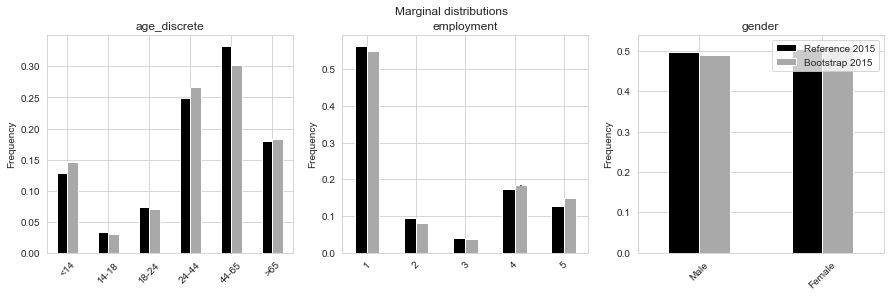

In [31]:
fig = plot_marginals_bootstrap(reference_data_2015, list_marginals, cols_1, labels_name_1, labels = ["Reference 2015", "Bootstrap 2015"])
fig.savefig("results/" + now + "/marginals_bootstrap_2015.png", dpi=300)

In [32]:
# Compute the mean and the confidence interval
bootstrap_stats_final = bootstrap_stats.T
bootstrap_stats_mean = bootstrap_stats_final.mean(axis=1)
bootstrap_stats_error = bootstrap_stats_final.quantile([0.025, 0.975], axis=1)
bootstrap_stats_error = bootstrap_stats_error.T
bootstrap_stats_error.columns = ['lower', 'upper']
bootstrap_stats_error['lower'] = bootstrap_stats_mean - bootstrap_stats_error['lower']
bootstrap_stats_error['upper'] = bootstrap_stats_error['upper'] - bootstrap_stats_mean
bootstrap_stats_error = bootstrap_stats_error[['lower', 'upper']].values.T

In [34]:
# Boxplot of the stats separated by columns in subplots
fig = make_subplots(rows=1, cols=len(bootstrap_stats_final), subplot_titles = bootstrap_stats_final.index, x_title="Value", y_title="Stat")
for i, stat in enumerate(bootstrap_stats_mean.index):
    fig.add_trace(go.Box(y=bootstrap_stats_final.loc[stat,:],boxpoints='all', name=stat), row = 1, col= i+1)
fig.update_layout(
    title="Synthetic data stats",
    width=1200,
    height=600,
)
fig.show()